### Get and Study Data

### Pending
* Feature Importance using XGBoost
* DIFFERENT Viz
* Prophet

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data_path = 'data/AAPL.csv'
df = pd.read_csv(data_path)

# Parse the 'Date' column and add it as a feature
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'] = df['Date'].map(lambda x: x.toordinal())  # Convert Date to numerical format

# Display basic information
df.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,723161,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,723164,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,723165,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,723166,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,723167,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


<Axes: xlabel='Close', ylabel='Density'>

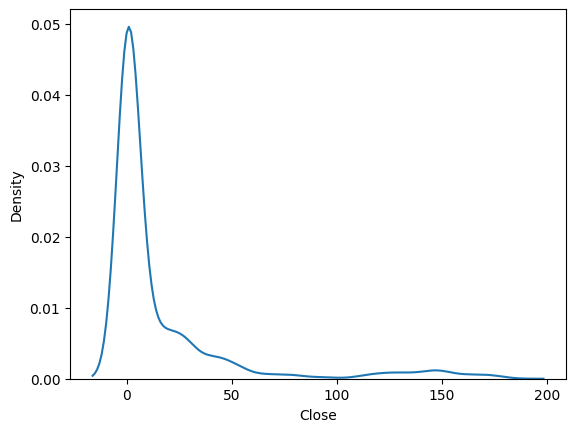

In [67]:
import seaborn as sns
sns.kdeplot(df['Close'])

#### Preprocessing

In [2]:
# Normalize all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns=['Close']))  # Scale input features

# Scale the target column 'Close'
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = target_scaler.fit_transform(df[['Close']])

# Define a function to create sequences for features and target
def create_sequences_multivariate(data, target, lookback):
    sequences = []
    targets = []
    for i in range(lookback, len(data)):
        sequences.append(data[i - lookback:i, :])  # Feature sequences
        targets.append(target[i, 0])  # Corresponding target value
    return np.array(sequences), np.array(targets)

# Set lookback window size
lookback = 30

# Create sequences for features and target
X, y = create_sequences_multivariate(scaled_data, scaled_close, lookback)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Print data shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (7392, 30, 6), y_train shape: (7392,)
X_val shape: (1584, 30, 6), y_val shape: (1584,)
X_test shape: (1584, 30, 6), y_test shape: (1584,)


#### Feature Importance

/var/folders/l9/6v9vn4rn71z0d0b27r8k7xtc0000gn/T/ipykernel_75939/4049650446.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=feature_names, palette="viridis")


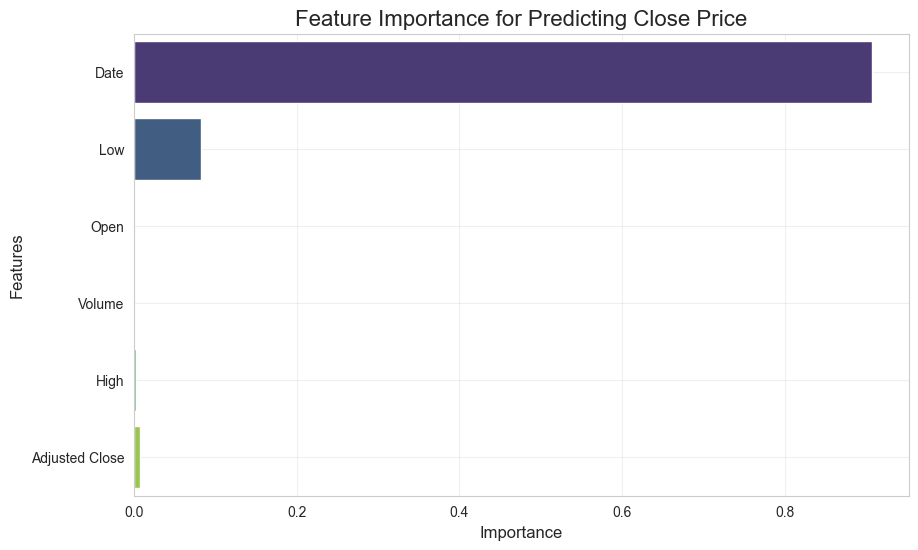

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Train a RandomForestRegressor to estimate feature importances
# Flatten X_train and reshape it for RandomForest (ignoring sequential structure for simplicity in feature importance analysis)
n_features = X_train.shape[2]
X_train_flat = X_train.reshape(-1, n_features)
y_train_flat = np.repeat(y_train, X_train.shape[1])  # Repeat targets to match the flattened structure

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train_flat)

# Extract feature importances
feature_importances = rf.feature_importances_

# Plot feature importance heatmap
def plot_feature_importance(importance, feature_names, title='Feature Importance Heatmap', figsize=(10, 6)):
    """
    Plots a heatmap of feature importances.

    Parameters:
    - importance: Array of feature importances
    - feature_names: List of feature names
    - title: Title of the plot
    - figsize: Figure size
    """
    plt.figure(figsize=figsize)
    sns.barplot(x=importance, y=feature_names, palette="viridis")
    plt.title(title, fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Get the feature names (columns except 'Close')
feature_names = df.drop(columns=['Close']).columns.tolist()

# Plot the feature importance heatmap
plot_feature_importance(feature_importances, feature_names, title='Feature Importance for Predicting Close Price')

### 1. Simple `SimpleRNN`

In [4]:
# Model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input

# Define the SimpleRNN model
simple_rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(50, activation='tanh'),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with SGD optimizer and MSE loss
simple_rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
simple_rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0029 - mae: 0.0270 - val_loss: 0.0093 - val_mae: 0.0914
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4821e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0271
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8737e-05 - mae: 0.0066 - val_loss: 0.0032 - val_mae: 0.0529
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0746e-05 - mae: 0.0055 - val_loss: 0.0024 - val_mae: 0.0462
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1592e-05 - mae: 0.0044 - val_loss: 0.0018 - val_mae: 0.0398
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7947e-05 - mae: 0.0041 - val_loss: 6.5042e-04 - val_mae: 0.0233
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 2.5552e-05 - mae: 0.0040 - val_loss: 2.0107e-04 - val_mae: 0.0112
Epoch 8/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3574e-05 - mae: 0.0037 - val_loss: 5.0653e-04 - val_mae: 0.0205
Epoch 9/15
231

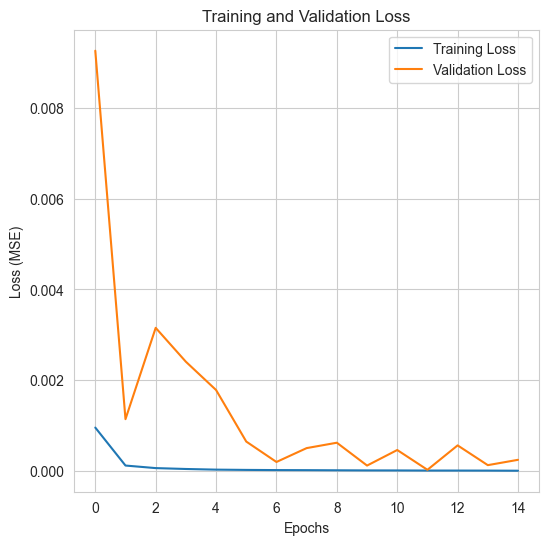

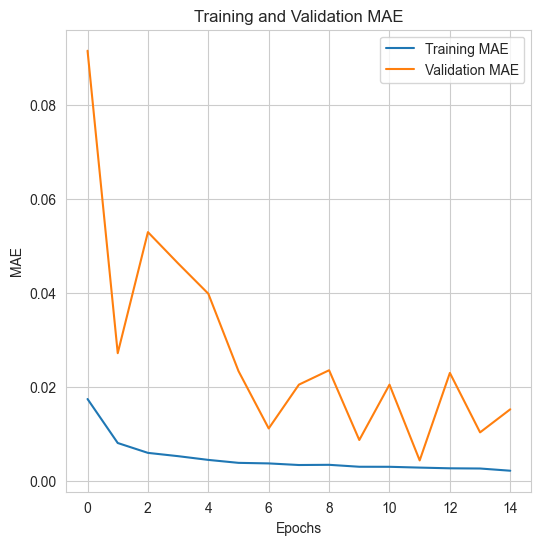

In [6]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()

### 2. Sophisticated `SimpleRNN`

In [7]:
# Model 2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Define the Sophisticated SimpleRNN model
sophisticated_rnn_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(64, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with Adam optimizer and MSE loss
sophisticated_rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
sophisticated_rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 30, 64)         │         4,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,681 (30.00 KB)

 Trainable params: 7,681 (30.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history_sophisticated = sophisticated_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4458 - mae: 0.1621 - val_loss: 0.0264 - val_mae: 0.0941
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - mae: 0.0062 - val_loss: 0.0124 - val_mae: 0.1053
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0448e-04 - mae: 0.0067 - val_loss: 0.0113 - val_mae: 0.0997
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0660e-05 - mae: 0.0060 - val_loss: 0.0099 - val_mae: 0.0931
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.7444e-05 - mae: 0.0063 - val_loss: 0.0127 - val_mae: 0.1067
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0093e-04 - mae: 0.0063 - val_loss: 0.0116 - val_mae: 0.1018
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3908e-05 - mae: 0.0061 - val_loss: 0.0112 - val_mae: 0.0997
Epoch 8/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0483e-05 - mae: 0.0060 - val_loss: 0.0118 - val_mae: 0.1027
Epoch 9/15
231/231 ━━━━━━━━━━━━━

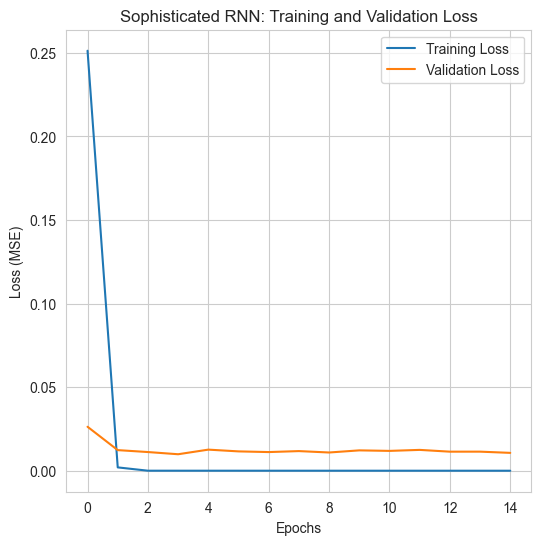

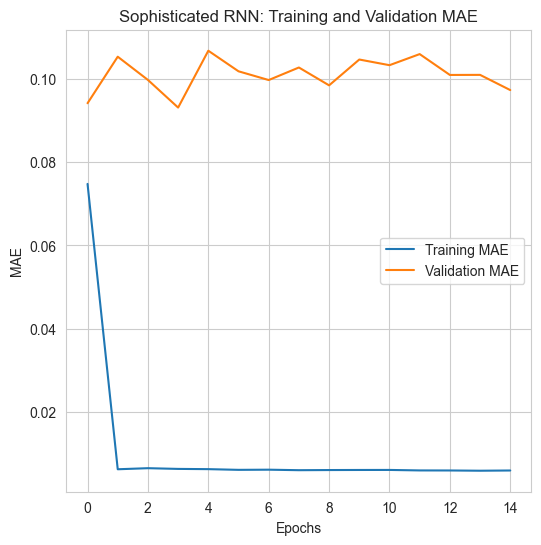

In [9]:
# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history_sophisticated.history['loss'], label='Training Loss')
plt.plot(history_sophisticated.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Sophisticated RNN: Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history_sophisticated.history['mae'], label='Training MAE')
plt.plot(history_sophisticated.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Sophisticated RNN: Training and Validation MAE')
plt.show()

### 3. `GRU`

In [10]:
# Model 3
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(16, activation='tanh', return_sequences=True),
    Dropout(0.2),
    Dense(1)  # Output layer for predicting the 'Close' price
])

# Compile the model with Adam optimizer and MSE loss
gru_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Display model summary
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 16)         │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the GRU model
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - mae: 0.0263 - val_loss: 0.0113 - val_mae: 0.0999
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9534e-04 - mae: 0.0102 - val_loss: 0.0136 - val_mae: 0.1111
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4170e-04 - mae: 0.0085 - val_loss: 0.0116 - val_mae: 0.1019
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1618e-04 - mae: 0.0074 - val_loss: 0.0119 - val_mae: 0.1030
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0743e-04 - mae: 0.0071 - val_loss: 0.0123 - val_mae: 0.1050
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0227e-04 - mae: 0.0068 - val_loss: 0.0123 - val_mae: 0.1050
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9421e-05 - mae: 0.0067 - val_loss: 0.0111 - val_mae: 0.0994
Epoch 8/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0757e-04 - mae: 0.0069 - val_loss: 0.0112 - val_mae: 0.1002
Epoch 9/30
231/231 ━━━━━━━━━

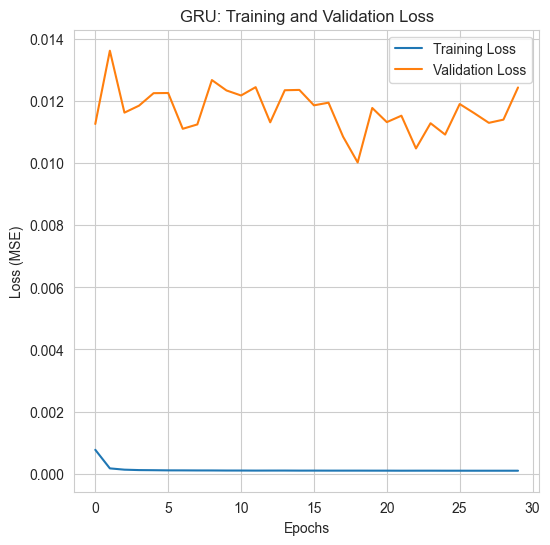

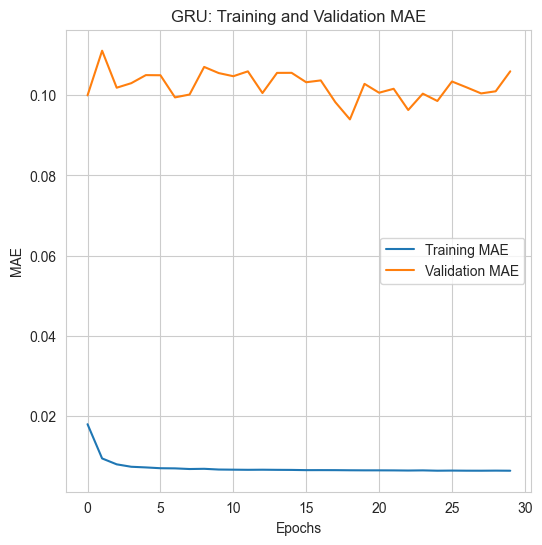

In [12]:
# Plot the loss curves
plt.figure(figsize=(6, 6))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('GRU: Training and Validation Loss')
plt.show()

# Plot the MAE curves
plt.figure(figsize=(6, 6))
plt.plot(history_gru.history['mae'], label='Training MAE')
plt.plot(history_gru.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('GRU: Training and Validation MAE')
plt.show()

### Simple `SimpleRNN` with `Adam`

In [112]:
# Compile the model with SGD optimizer and MSE loss
simple_rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model summary
simple_rnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, 50)             │         2,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,901 (11.33 KB)

 Trainable params: 2,901 (11.33 KB)

 Non-trainable params: 0 (0.00 B)

In [113]:
# Train the model
history = simple_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.5713e-06 - mae: 0.0018 - val_loss: 1.7047e-05 - val_mae: 0.0032
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8440e-07 - mae: 5.0764e-04 - val_loss: 3.5735e-05 - val_mae: 0.0050
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7581e-07 - mae: 6.5927e-04 - val_loss: 3.1295e-05 - val_mae: 0.0048
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0753e-06 - mae: 7.3395e-04 - val_loss: 1.2049e-05 - val_mae: 0.0025
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8108e-07 - mae: 6.3028e-04 - val_loss: 2.6463e-05 - val_mae: 0.0041
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0512e-06 - mae: 6.2443e-04 - val_loss: 9.1863e-06 - val_mae: 0.0022
Epoch 7/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2273e-07 - mae: 3.9770e-04 - val_loss: 3.9630e-05 - val_mae: 0.0050
Epoch 8/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3354e-06 - mae: 0.0010 - val_los

In [119]:
simple_rnn_model.evaluate(X_test, y_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 2.3519e-04 - mae: 0.0084


[0.0010749255307018757, 0.02122870646417141]